# Cyclosporin A Cluster Simulator

**by Xavier Tao using code by Tyler Backman**

Cluster data referenced from "Nonribosomal Peptide Synthetases Involved in the Production of Medically Relevant Natural Products", by Felnagle et. al.
https://pubs.acs.org/doi/10.1021/mp700137g

Template SDF file for Cyclosporin A from https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:4031

Note: this notebook must be run inside of a working version of ClusterCAD

In [1]:
# Connect to ClusterCAD
import os, sys
sys.path.insert(0, '/clusterCAD')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "clusterCAD.settings")
import django
django.setup()
import pks.models

# import libraries
from pks.models import Domain
from rdkit import Chem as chem
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from django.db import models

In [2]:
def plotMol(mol):
    # function to plot a target chemical structure and compare to a template
    template = chem.MolFromMolFile('input_data/cyclosporin a (noncircular).sdf')
    
    mcs = rdFMCS.FindMCS([mol, template], matchChiralTag=False, matchValences=False)
    atoms = [atom.GetIdx() for atom in template.GetAtoms()]
    mcsSmarts = chem.MolFromSmarts(mcs.smartsString)
    highlightAtomList1 = template.GetSubstructMatch(mcsSmarts)
    highlightAtomList2 = mol.GetSubstructMatch(mcsSmarts)
    nonMCSatoms = list(filter(lambda x: x not in highlightAtomList1, atoms))
    nonMCSatoms.sort(reverse=True)
    rwmol = chem.RWMol(template)
    for atom in nonMCSatoms:
        rwmol.RemoveAtom(atom)
    templateMol = rwmol.GetMol()
    AllChem.GenerateDepictionMatching2DStructure(mol, templateMol, acceptFailure=False)
    return Draw.MolsToGridImage([mol], legends=[''], molsPerRow=1, useSVG=True, subImgSize=(600, 600))
    # return Draw.MolsToGridImage([mol], legends=[''], molsPerRow=1, highlightAtomLists=[highlightAtomList2], useSVG=True, subImgSize=(600, 600))

In [3]:
# NRPS domains, directly taken and modified from models.py

aminoAcids = {
    # L-amino acids - use format <R_group>C[C@H](N)C(=O)[S] for L stereochemistry
    # cleaned up smiles with https://pubchem.ncbi.nlm.nih.gov//edit3/index.html or https://cactus.nci.nih.gov/translate/
    
    # special
    'gly': chem.MolFromSmiles('NCC(=O)[S]'),
    'cys': chem.MolFromSmiles('SC[C@H](N)C(=O)[S]'),
    'pro': chem.MolFromSmiles('C1CC[C@H](N1)C(=O)[S]'),
    
    # polar uncharged
    'ser': chem.MolFromSmiles('OC[C@H](N)C(=O)[S]'),
    'thr': chem.MolFromSmiles('CC(O)[C@H](N)C(=O)[S]'),
    'asn': chem.MolFromSmiles('NC(=O)C[C@H](N)C(=O)[S]'),
    'gln': chem.MolFromSmiles('NC(=O)CC[C@H](N)C(=O)[S]'),
    
    # polar charged
    'arg': chem.MolFromSmiles('N=C(N)NCCC[C@H](N)C(=O)[S]'),
    'his': chem.MolFromSmiles('N1=CNC=C1C[C@H](N)C(=O)[S]'),
    'lys': chem.MolFromSmiles('NCCCC[C@H](N)C(=O)[S]'),
    'asp': chem.MolFromSmiles('OC(=O)C[C@H](N)C(=O)[S]'),
    'glu': chem.MolFromSmiles('OC(=O)CC[C@H](N)C(=O)[S]'),
    
    # nonpolar
    'ala': chem.MolFromSmiles('C[C@H](N)C(=O)[S]'),
    'val': chem.MolFromSmiles('CC(C)[C@H](N)C(=O)[S]'),
    'ile': chem.MolFromSmiles('CCC(C)[C@H](N)C(=O)[S]'),
    'leu': chem.MolFromSmiles('CC(C)C[C@H](N)C(=O)[S]'),
    'met': chem.MolFromSmiles('CSCC[C@H](N)C(=O)[S]'),
    'phe': chem.MolFromSmiles('C1=CC=CC=C1C[C@H](N)C(=O)[S]'),
    'tyr': chem.MolFromSmiles('C1=CC(O)=CC=C1C[C@H](N)C(=O)[S]'),
    'trp': chem.MolFromSmiles('C2=CC=CC1=C2C(=CN1)C[C@H](N)C(=O)[S]'), 
    
    # amino acid derivatives
    'pip': chem.MolFromSmiles('C1CC[N]C(C1)C(=O)[S]'),
    'd-ala': chem.MolFromSmiles('C[C@@H](N)C(=O)[S]'),
    'bmt': chem.MolFromSmiles('C/C=C/[C@@H](C)[C@@H](O)C(N)C(=O)[S]'),
    'aba': chem.MolFromSmiles('CC[C@H](N)C(=O)[S]'),
}

class A():
    # Adenylation domain: picks substrate and catalyzes its addition to PCP

    SUBSTRATE_CHOICES = tuple(((k, k) for k in list(set(list(aminoAcids.keys())))))

    substrate = ''
    '''
    substrate = models.CharField(
        max_length=20,
        choices=SUBSTRATE_CHOICES,
        default='gly', # simplest amino acid
        blank=False,
    )
    '''
    def operation(self, chain):
        if not chain:
            return aminoAcids[self.substrate] # if there's no chain, then just pass on the substrate
        else:
            rxn = AllChem.ReactionFromSmarts(('[C:2](=[O:3])[S:1].' # incoming chain
                                              '[N:6][C:7][C:8](=[O:9])[S:10]>>' # substrate
                                              '[C:2](=[O:3])[N:6][C:7][C:8](=[O:9])[S:10]' # product
                                              '.[S:1]')) # remaining thiol
            
            # make sure there is only one thiol ester (electrophilic reaction site) substructure in the chain
            # then run the reaction
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('CC(=O)S'),
                       useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain, aminoAcids[self.substrate]))[0][0]
            chem.SanitizeMol(prod)
            return prod

    def __str__(self):
        return 'substrate %s' % (self.substrate)

    def __repr__(self):
        return ("A")


class Cy():
    # (hetero)Cyclization domain: picks substrate and cyclizes it, forming thiazoline or oxazoline
    # Currently can only cyclize using cysteine and serine/threonine and requires a chain

    SUBSTRATE_CHOICES = tuple(((k, k) for k in list(set(list(aminoAcids.keys())))))

    '''substrate = ''
    
    substrate = models.CharField(
        max_length=20,
        choices=SUBSTRATE_CHOICES,
        default='gly', # simplest amino acid
        blank=False,
    )
    '''
    def operation(self, chain):
        
        # ensures that a chain preceeds cyclization domain
        assert chain
        
        # first step - condensation
        rxn1 = AllChem.ReactionFromSmarts(('[C:2](=[O:3])[S:1]' # incoming chain
                                          '.[N:6][C:7][C:8](=[O:9])[S:10]>>' # substrate
                                          '[C:2](=[O:3])[N:6][C:7][C:8](=[O:9])[S:10]' # product
                                          '.[S:1]')) # remaining thiol

        # make sure there is only one thiol ester reaction site
        assert len(chain.GetSubstructMatches(chem.MolFromSmiles('CC(=O)S'),
                   useChirality=True)) == 1, chem.MolToSmiles(chain)
        intermediate = rxn1.RunReactants((chain, aminoAcids[self.substrate]))[0][0]
        chem.SanitizeMol(intermediate)
        
        print(chem.MolToSmiles(intermediate))

        # Cysteine -> Thiazoline case | second step - intramolecular cyclization
        if self.substrate == 'cys':
            rxn2 = AllChem.ReactionFromSmarts(('[C:11]C(=[O:3])[N:6][C:7]([C:5]S)[C:8](=[O:9])[S:10]>>' # condensation product backbone with thiol nucleophile
                                               '[C:11]C1=[N:6][C:7]([C:5]S1)[C:8](=[O:9])[S:10]' # thiazoline
                                               '.[O:3]')) # water from dehydration

            # make sure there is only one thiol ester-linked cyclization backbone
            assert len(intermediate.GetSubstructMatches(chem.MolFromSmiles('C(=O)NC(CS)C(=O)S'),
                   useChirality=True)) == 1, chem.MolToSmiles(intermediate)
            prod = rxn2.RunReactants((intermediate,))[0][0] # intramolecular rxn
            chem.SanitizeMol(prod)
            return prod

        # Threonine/Serine -> Oxazoline case | second step - intramolecular cyclization
        elif (self.substrate == 'thr' or self.substrate == 'ser'):
            rxn2 = AllChem.ReactionFromSmarts(('[C:11]C(=[O:3])[N:6][C:7]([C:5]O)[C:8](=[O:9])[S:10]>>' # condensation product backbone with alcohol nucleophile
                                               '[C:11]C1=[N:6][C:7]([C:5]O1)[C:8](=[O:9])[S:10]' # oxazoline
                                               '.[O:3]')) # water from dehydration

            # make sure there is only one thiol ester-linked cyclization backbone
            assert len(intermediate.GetSubstructMatches(chem.MolFromSmiles('C(=O)NC(CO)C(=O)S'),
                   useChirality=True)) == 1, chem.MolToSmiles(intermediate)
            prod = rxn2.RunReactants((intermediate,))[0][0] # intramolecular rxn
            chem.SanitizeMol(prod)
            return prod

        # Cyclization for everything else not supported and returns uncyclized intermediate
        else: 
            return intermediate

    def __str__(self):
        return 'substrate %s' % (self.substrate)

    def __repr__(self):
        return ("Cy")

class Ox():
    # Oxidation domain: Oxidizes thiazolines and oxazolines into thiazoles and oxazoles
    # the operation function assumes Ox immediately follows Cy domain

    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):
        
        #this is 1
        #print(len(chain.GetSubstructMatches(chem.MolFromSmiles('C1=NC(CO1)C(=O)S'), useChirality=True)))
        #this is 0
        #print(len(chain.GetSubstructMatches(chem.MolFromSmiles('*CCC(=O)S'), useChirality=True)))
        
        # checks if moiety to oxidize is thiazoline - if so, oxidizes to thiazol
        if len(chain.GetSubstructMatches(chem.MolFromSmiles('C1=NC(CS1)C(=O)S'), useChirality=True)) == 1 and self.active == True:
            rxn = AllChem.ReactionFromSmarts(('[C:11]C1=[N:6][CH1:7]([C:5]S1)[C:8](=[O:9])[S:10]>>'
                                              '[C:11]C1=[N:6][CH0:7](=[C:5]S1)[C:8](=[O:9])[S:10]'))
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        
        # checks if moiety to oxidize is oxazoline - if so, oxidizes to oxazole
        elif len(chain.GetSubstructMatches(chem.MolFromSmiles('C1=NC(CO1)C(=O)S'), useChirality=True)) == 1 and self.active == True:
            rxn = AllChem.ReactionFromSmarts(('[C:11]C1=[N:6][CH1:7]([C:5]O1)[C:8](=[O:9])[S:10]>>'
                                              '[C:11]C1=[N:6][CH0:7](=[C:5]O1)[C:8](=[O:9])[S:10]'))
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        
        # does not oxidize if moiety is neither oxazoline or thiazoline
        else:
            return chain

    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("Ox")
    
class E():
    # Epimerization domain: Epimerizes L-amino acids to D-amino acids
    
    # active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):
        # should ignore gly, smallest amino acid recognized is ala
        # technically does not work on thiazoline/oxazol type cyclic amino acids -- don't know if we'll see those cases
        
        # ensures if moiety to epimerize is a non-cyclized L-amino acid - if so, epimerizes to D-amino acid
        if self.active == True:
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('C[C@H](N)C(=O)[S]'),
                   useChirality=True)) == 1, chem.MolToSmiles(chain)
            rxn = AllChem.ReactionFromSmarts(('[C:5][C@H:7]([N:6])[C:8](=[O:9])[S:10]>>'
                                              '[C:5][C@@H:7]([N:6])[C:8](=[O:9])[S:10]'))
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("E")

class nMT():
    # N-methylation domain: methylates amine
    
    #active = models.BooleanField(default=True)
    active = True
    
    def operation(self, chain):

        if self.active == True:
            rxn = AllChem.ReactionFromSmarts(('[N:6][C:7][C:8](=[O:9])[S:10]>>'
                                              '[N:6](C)[C:7][C:8](=[O:9])[S:10]'))
            
            # make sure there is only one nitrogen reaction site
            assert len(chain.GetSubstructMatches(chem.MolFromSmiles('NCC(=O)S'),
                       useChirality=True)) == 1, chem.MolToSmiles(chain)
            prod = rxn.RunReactants((chain,))[0][0]
            chem.SanitizeMol(prod)
            return prod
        else:
            return chain
    
    def __str__(self):
        return activityString(self)

    def __repr__(self):
        return ("nMT")

In [4]:
# Define some domains
A_domain = A()
nMT_domain = nMT()

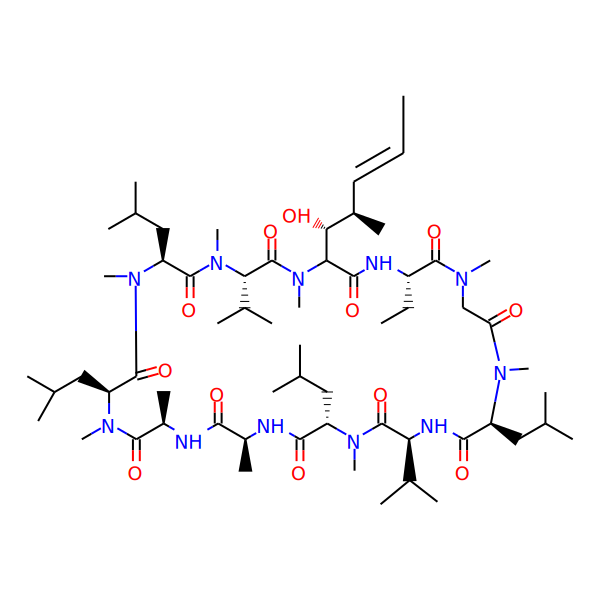

In [5]:
#Cyclosporin A biosynthetic gene cluster modules

#Module 1
A_domain.substrate = 'd-ala'
p1 = A_domain.operation(chain=False)
chem.SanitizeMol(p1)
plotMol(p1)

#Module 2
A_domain.substrate = 'leu'
p2a = A_domain.operation(chain=p1)
p2 = nMT_domain.operation(chain=p2a)
chem.SanitizeMol(p2)
plotMol(p2)

#Module 3
A_domain.substrate = 'leu'
p3a = A_domain.operation(chain=p2)
p3 = nMT_domain.operation(chain=p3a)
chem.SanitizeMol(p3)
plotMol(p3)

#Module 4
A_domain.substrate = 'val'
p4a = A_domain.operation(chain=p3)
p4 = nMT_domain.operation(chain=p4a)
chem.SanitizeMol(p4)
plotMol(p4)

#Module 5
A_domain.substrate = 'bmt'
p5a = A_domain.operation(chain=p4)
p5 = nMT_domain.operation(chain=p5a)
chem.SanitizeMol(p5)
plotMol(p5)

#Module 6
A_domain.substrate = 'aba'
p6 = A_domain.operation(chain=p5)
chem.SanitizeMol(p6)
plotMol(p6)

#Module 7
A_domain.substrate = 'gly'
p7a = A_domain.operation(chain=p6)
p7 = nMT_domain.operation(chain=p7a)
chem.SanitizeMol(p7)
plotMol(p7)

#Module 8
A_domain.substrate = 'leu'
p8a = A_domain.operation(chain=p7)
p8 = nMT_domain.operation(chain=p8a)
chem.SanitizeMol(p8)
plotMol(p8)

#Module 9
A_domain.substrate = 'val'
p9 = A_domain.operation(chain=p8)
chem.SanitizeMol(p9)
plotMol(p9)

#Module 10
A_domain.substrate = 'leu'
p10a = A_domain.operation(chain=p9)
p10 = nMT_domain.operation(chain=p10a)
chem.SanitizeMol(p10)
plotMol(p10)

#Module 11 - C-terminal C-domain cyclizes
A_domain.substrate = 'ala'
p11a = A_domain.operation(chain=p10)
chem.SanitizeMol(p11a)

# note to self: remember to use parenthesis around both "reactant moieties" in an intramolecular SMARTS
rxn = AllChem.ReactionFromSmarts('([C:8](=[O:9])[S:10].[C:5][C@@H:6]([NH2:1])[C:3](=[O:4]))>>'
                                  '([C:5][C@@H:6]([NH1:1][C:8](=[O:9]))[C:3](=[O:4])).[S:10]')

p11 = rxn.RunReactants((p11a,))[0][0]
chem.SanitizeMol(p11)
plotMol(p11)